In [29]:
import os

import matplotlib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import yfinance as yf
INPUT_WINDOW_SIZE = 15
OUTPUT_WINDOW_SIZE = 5

In [30]:


from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
import sys
sys.path.insert(0,'../../../..')
from Backtesting.SingleTickerBacktesting import SimplePortfolioExperiment
from source.source import prepare_data


In [47]:
TICKERS = ["AAPL", "MSFT", "NFLX", "GOOG", "AMZN"]
X = {}
y = {}
X_trade = {}
for ticker in TICKERS:
    t = yf.Ticker(ticker)
    prices = t.history(start="2011-01-01", end="2020-12-31",
                          interval='1d').Close
    X_t, y_t = prepare_data(prices, OUTPUT_WINDOW_SIZE, INPUT_WINDOW_SIZE)
    trade_prices = t.history(start="2021-01-01", end="2021-12-31",
                          interval='1d').Close
    X[ticker] = X_t
    y[ticker] = y_t
    X_trade[ticker] = trade_prices

In [48]:
len(X["GOOG"])

500

In [61]:
X_train = [X[ticker][:400] for ticker in X.keys()]
X_test  = [X[ticker][400:] for ticker in X.keys()]
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

y_train = [y[ticker][:400] for ticker in y.keys()]
y_test = [y[ticker][400:] for ticker in y.keys()]
y_train = np.vstack(y_train)
y_test = np.vstack(y_test)

In [82]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
param_grid = {
    "model__alpha":np.arange(0, 10, 0.1),
    "model__max_iter":np.arange(1000, 10000, 1000)
}
pipe_model = Pipeline([
    ("poly_features", PolynomialFeatures((2, 3))),
    ('model', Ridge(random_state=7475))
],verbose=False)

grid_search = GridSearchCV(
    pipe_model, param_grid=param_grid,
    scoring="neg_mean_absolute_percentage_error",
    verbose=2
)


In [83]:
from sklearn.model_selection import PredefinedSplit

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] END .............model__alpha=0.0, model__max_iter=1000; total time=   0.4s
[CV] END .............model__alpha=0.0, model__max_iter=1000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=1000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=1000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=1000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=2000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=2000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=2000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=2000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=2000; total time=   0.3s
[CV] END .............model__alpha=0.0, model__max_iter=3000; total time=   0.3s
[CV] END .............model__alpha=0.0, model

GridSearchCV(estimator=Pipeline(steps=[('poly_features',
                                        PolynomialFeatures(degree=(2, 3))),
                                       ('model', Ridge(random_state=7475))]),
             param_grid={'model__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'model__max_iter': array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [85]:
grid_search.best_params_

{'model__alpha': 0.30000000000000004, 'model__max_iter': 1000}

In [86]:
grid_search.best_score_

-0.03276082545962231

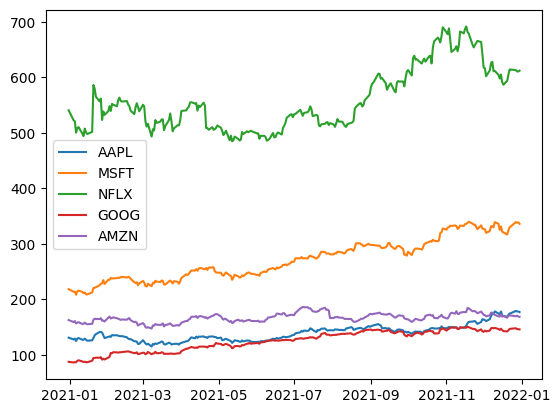

In [99]:
from matplotlib import pyplot as plt
for ticker in TICKERS:
    plt.plot(X_trade[ticker], label=ticker)
plt.legend()
plt.show()

In [106]:
main_model = grid_search.best_estimator_

In [101]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [119]:
from source.source import _transform_to_DOIU

d = _transform_to_DOIU(X_trade["MSFT"][:INPUT_WINDOW_SIZE + OUTPUT_WINDOW_SIZE])
y_true = d[-1]
mape([y_true], main_model.predict(d[:INPUT_WINDOW_SIZE].reshape(1, -1)))

0.013216620798712502

In [124]:
mape(y_test, main_model.predict(X_test))

0.03087047485582866

In [144]:
import pickle
#pickle.dump(main_model, open("/Users/eplyushch/projects/Stock_price_prediction/research/zhekuson/linear_models/linreg/best_ridge_pipe.pkl", 'wb'))

#loaded_model = pickle.load(open("", 'rb'))

Experiments

In [1]:
import sys
sys.path += ["/Users/eplyushch/projects/Stock_price_prediction"]

In [2]:
INPUT_WINDOW_SIZE=15
OUTPUT_WINDOW_SIZE=5

In [3]:
import yfinance as yf
from source.source import prepare_data, _transform_to_DOIU
from Backtesting.SingleTickerBacktesting import SimplePortfolioExperiment
TICKERS = ["AAPL", "MSFT", "NFLX", "GOOG", "AMZN", "YNDX"]
X = {}
y = {}
X_trade = {}
for ticker in TICKERS:
    t = yf.Ticker(ticker)
    prices = t.history(start="2011-01-01", end="2020-12-31",
                          interval='1d').Close
    X_t, y_t = prepare_data(prices, OUTPUT_WINDOW_SIZE, INPUT_WINDOW_SIZE)
    trade_prices = t.history(start="2021-01-01", end="2021-12-31",
                          interval='1d').Close
    X[ticker] = X_t
    y[ticker] = y_t
    X_trade[ticker] = trade_prices

In [4]:
import pickle
main_model = pickle.load(open("best_ridge_pipe.pkl", 'rb'))
main_model

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=(2, 3))),
                ('model',
                 Ridge(alpha=0.30000000000000004, max_iter=1000,
                       random_state=7475))])

In [5]:
class RidgeExperiment(SimplePortfolioExperiment):
    def __init__(self, BUY_THR = 0.01, SELL_THR=0.005, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.BUY_THR = BUY_THR
        self.SELL_THR = SELL_THR
        self.predictions = []
        self.action_idxs = []
        self.sell_idxs = []
        self.buy_idxs = []
        self.hold_idxs = []

    def make_action(self, ind):
        self.action_idxs.append(ind)

        if ind < INPUT_WINDOW_SIZE:
            return
        else:
            prices = _transform_to_DOIU(
                self.historical_data[ind-INPUT_WINDOW_SIZE:ind]
            )
            prediction = main_model.predict(prices.reshape(1,-1))
            self.predictions.append(prediction * self.historical_data[ind-INPUT_WINDOW_SIZE])
            rel_predict = (prediction - prices[-1]) / prices[-1]
            if rel_predict > self.BUY_THR:
                self.buy_stocks_per_money(self.free_money, ind)
                self.buy_idxs.append(ind)
            elif rel_predict < -self.SELL_THR:
                self.sell_papers(self.number_of_stocks, ind)
                self.sell_idxs.append(ind)
            else:
                rel_change = rel_predict / abs(self.BUY_THR + self.SELL_THR)
                if rel_change > 0:
                    self.buy_stocks_per_money(rel_change * self.free_money,
                                     ind, partial_operation=True)
                    self.buy_idxs.append(ind)
                elif rel_change < 0:
                    self.sell_partial_papers(-rel_change,
                                             ind, partial_operation=True)
                    self.sell_idxs.append(ind)
                else:
                    self.hold_idxs.append(ind)




class BaselineExperiment(SimplePortfolioExperiment):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.predictions = []
        self.action_idxs = []
        self.sell_idxs = []
        self.buy_idxs = []
        self.hold_idxs = []

    def make_action(self, ind):
        self.buy_stocks_per_money(self.free_money, ind)
        self.buy_idxs.append(ind)


In [6]:
START_CAPITAL = 50000
baseline_exp = BaselineExperiment(
    historical_data=X_trade["YNDX"],
                      money_to_add=0,
                      start_capital=START_CAPITAL,
                      days_per_action=OUTPUT_WINDOW_SIZE,
                      window_size=INPUT_WINDOW_SIZE
)
exp = RidgeExperiment(historical_data=X_trade["YNDX"],
                      money_to_add=0,
                      start_capital=START_CAPITAL,
                      days_per_action=OUTPUT_WINDOW_SIZE,
                      window_size=INPUT_WINDOW_SIZE)

In [7]:
exp.start_experiment()
baseline_exp.start_experiment()

Start portfolio experiment.


100%|██████████| 251/251 [00:00<00:00, 2692.29it/s]


Start portfolio experiment.


100%|██████████| 251/251 [00:00<00:00, 136175.18it/s]


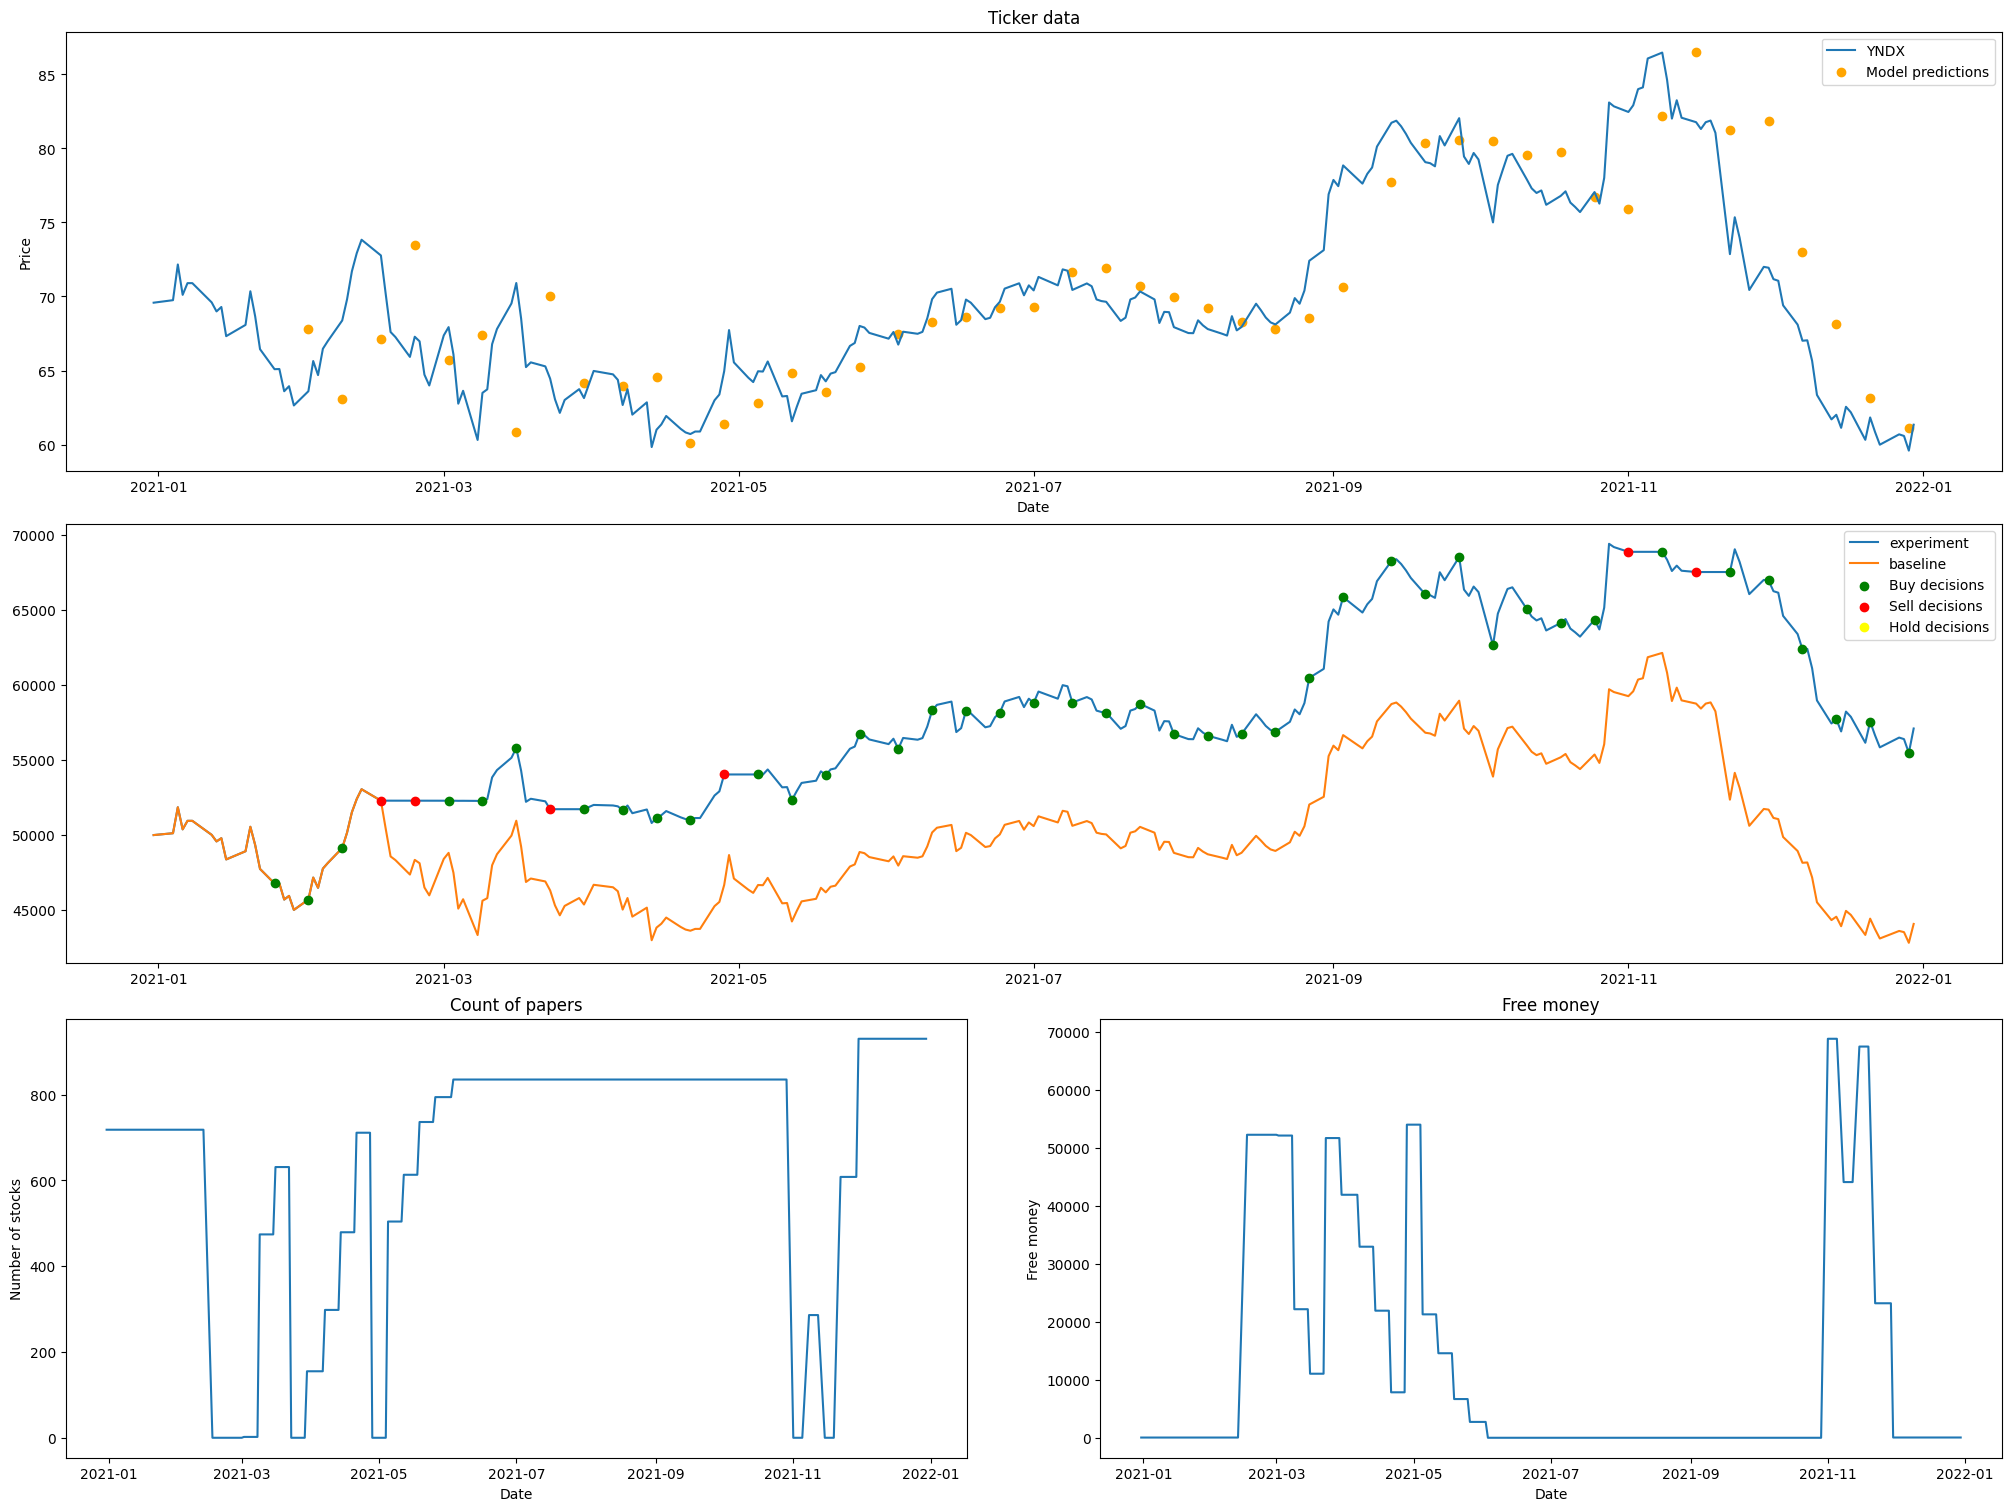

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib
plt.ioff()
#matplotlib.use('Agg')
#plt.style.use("seaborn-v0_8-dark")
def plot_baseline_and_exp(exp, baseline_exp, ticker_data,
                          ticker_name, filename=None, show=False):
    fig = plt.figure(constrained_layout=True, figsize=(20,15))

    gs = GridSpec(3, 2, figure=fig)
    axes = [fig.add_subplot(gs[0, :]),
            fig.add_subplot(gs[1, :]),
            fig.add_subplot(gs[2, 0]),
            fig.add_subplot(gs[2, 1])]
    axes[0].set_title("Ticker data")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Price")
    common_x = ticker_data.index
    axes[0].plot(common_x, ticker_data, label=ticker_name)

    pred_idx = np.array(exp.action_idxs) + OUTPUT_WINDOW_SIZE
    pred_idx = np.extract(pred_idx < len(common_x), pred_idx)
    predictions = np.stack(exp.predictions).flatten()
    axes[0].scatter(common_x[pred_idx],
            predictions[:len(pred_idx)],
            marker="o", label="Model predictions", color="orange")
    axes[0].legend()
    #####
    axes[1].plot(common_x, exp.history_capital, label="experiment")
    axes[1].plot(common_x, baseline_exp.history_capital, label="baseline")
    axes[1].scatter(common_x[exp.buy_idxs],
                    np.array(exp.history_capital)[exp.buy_idxs],
                    marker="o", label="Buy decisions",
                    color="green", zorder=2)
    axes[1].scatter(common_x[exp.sell_idxs],
                    np.array(exp.history_capital)[exp.sell_idxs],
                    marker="o", label="Sell decisions",
                    color="red", zorder=2)
    axes[1].scatter(common_x[exp.hold_idxs],
                    np.array(exp.history_capital)[exp.hold_idxs],
                    marker="o", label="Hold decisions",
                    color="yellow", zorder=2)
    axes[1].legend()
    #####
    axes[2].set_title("Count of papers")
    axes[2].set_xlabel("Date")
    axes[2].set_ylabel("Number of stocks")

    axes[2].plot(common_x, exp.history_stocks)
    ####
    axes[3].set_title("Free money")
    axes[3].set_xlabel("Date")
    axes[3].set_ylabel("Free money")

    axes[3].plot(common_x, exp.history_free_money)
    ####

    if filename is not None:
        plt.savefig(f"images/{filename}.png")
    if show:
        plt.show()

plot_baseline_and_exp(exp, baseline_exp, X_trade["YNDX"],
                      ticker_name="YNDX", filename="yndx_50000", show=True)

In [10]:
exp.history_capital[-1] - baseline_exp.history_capital[-1]

13011.072875976562

In [18]:
from tqdm.notebook import tqdm
import os
START_CAPITAL = 50000
SELL_THRs = np.round(np.arange(0.01, 0.045, 0.005), decimals=3)
BUY_THRs = np.round(np.arange(0.01, 0.045, 0.005), decimals=3)
results = {ticker:{} for ticker in TICKERS}
for ticker in TICKERS:
    os.mkdir(f"images/{ticker}")
for ticker in TICKERS:
    print(ticker)
    baseline_exp = BaselineExperiment(
            historical_data=X_trade[ticker],
                              money_to_add=0,
                              start_capital=START_CAPITAL,
                              days_per_action=OUTPUT_WINDOW_SIZE,
                              window_size=INPUT_WINDOW_SIZE,
        verbose=False
            )
    baseline_exp.start_experiment()
    for sell_thr in tqdm(SELL_THRs, position=0, desc="sell_thr"):
        for buy_thr in tqdm(BUY_THRs, position=1, desc="buy_thr", leave=False):
            exp = RidgeExperiment(
                historical_data=X_trade[ticker],
                money_to_add=0,
                              start_capital=START_CAPITAL,
                              days_per_action=OUTPUT_WINDOW_SIZE,
                              window_size=INPUT_WINDOW_SIZE,
                SELL_THR=sell_thr,
                BUY_THR=buy_thr,
                verbose=False
            )
            exp.start_experiment()
            results[ticker][(buy_thr, sell_thr)] = (exp.history_capital[-1] -
                                            baseline_exp.history_capital[-1])/START_CAPITAL
            plot_baseline_and_exp(exp, baseline_exp,
                                  ticker_data=X_trade[ticker],
                                  ticker_name=ticker, show=False,
                                  filename=f"{ticker}/{buy_thr}_{sell_thr}_{ticker}")

AAPL


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

MSFT


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

NFLX


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

GOOG


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

AMZN


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

YNDX


sell_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

buy_thr:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
sorted(results["AAPL"].items(), key=lambda x: x[1], reverse=True)[0]

((0.01, 0.01), 0.052934135284423825)

In [38]:
import pandas as pd
best_results = {ticker:sorted(results[ticker].items(), key=lambda x: x[1],
                              reverse=True)[0] for ticker in TICKERS}
best_results = pd.DataFrame(best_results, index=["buy/sell thr", "best result in percent"])

In [37]:
best_results


,AAPL,MSFT,NFLX,GOOG,AMZN,YNDX
0,"(0.01, 0.01)","(0.01, 0.04)","(0.02, 0.01)","(0.01, 0.04)","(0.01, 0.04)","(0.01, 0.01)"
1,0.052934,-0.008281,0.05712,-0.00526,-0.003557,0.130988
